### Consider having discrete values for DEM basins

In [1]:
install.packages("na.tools")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(caret)
library(pscl)
library(plotROC)
library(pROC)
library(sf)
library(tidyverse)
library(knitr)
library(kableExtra)
library(tigris)
library(ggthemes)
library(rgdal)
library(raster)
library(rgeos)
library(viridis)
library(ggmap)
library(gridExtra)
library(raster)
library(extrafont)
library(na.tools)

  
q5 <- function(variable) {
    as.factor(ntile(variable, 5))}

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:plotROC’:

    ggroc


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks

In [3]:
pal<- c("#ffa600", "#58508d")

mapTheme <- theme(plot.title =element_text(size=12),
                  plot.subtitle = element_text(size=8),
                  plot.caption = element_text(size = 6),
                  axis.line=element_blank(),
                  axis.text.x=element_blank(),
                  axis.text.y=element_blank(),
                  axis.ticks=element_blank(),
                  axis.title.x=element_blank(),
                  axis.title.y=element_blank(),
                  panel.background=element_blank(),
                  panel.border=element_blank(),
                  panel.grid.major=element_line(colour = 'transparent'),
                  panel.grid.minor=element_blank(),
                  legend.direction = "vertical", 
                  legend.position = "right",
                  plot.margin = margin(1, 1, 1, 1, 'cm'),
                  legend.key.height = unit(1, "cm"), legend.key.width = unit(0.2, "cm"))

In [4]:
nai_bound <- st_as_sf(st_read('/kaggle/input/boundary/Nairobi_County.shp'), crs=4326) %>% st_transform('EPSG:21037')

fishnet <- st_as_sf(st_read('/kaggle/input/floods-datasets/fishnet.shp'))
fishnet$OID <- rownames(fishnet)

flood <- st_as_sf(st_read('/kaggle/input/flood-ev/flood.shp'))

# Dependent var
flood_events <- read.csv('/kaggle/input/floods-datasets/flood.csv') %>%
    dplyr::select(OID_, Nairobi_Flood_Plains_CopyRas2) %>%
    rename(FLOOD_INNUN = Nairobi_Flood_Plains_CopyRas2, OID = OID_) 

# replace na values with 0 and the rest of the data with 1
flood_events$FLOOD_INNUN <- ifelse(is.na(flood_events$FLOOD_INNUN), 0, 1)

# Predictor var
ndvi <- read.csv('/kaggle/input/data-add-weight/Nai_NDVI.csv') %>%
    dplyr::select(OID_, Nai_NDVI_Extract) %>%
    rename(OID = OID_, NDVI = Nai_NDVI_Extract)

buildings <- read.csv('/kaggle/input/data-add-weight/nai_buildings_Sample.csv') %>%
    dplyr::select(OID_, Building_Count) %>%
    rename(OID = OID_, BUILDINGS = Building_Count)

water_bodies <- read.csv('/kaggle/input/water-merged/Waters_Bodies.csv') %>%
    dplyr::select(OID_, PERCENTAGE) %>%
    rename(OID = OID_, WATERBODY = PERCENTAGE)

rivers <- read.csv('/kaggle/input/floods-datasets/rivers.csv') %>%
    dplyr::select(OID_, Shape_Length) %>%
    rename(OID = OID_, RIVER = Shape_Length)

stream <- read.csv('/kaggle/input/floods-datasets/stream.csv') %>%
    dplyr::select(OID_, Shape_Length) %>%
    rename(OID = OID_, STREAM = Shape_Length)

drainage <- read.csv('/kaggle/input/floods-datasets/drains.csv') %>%
    dplyr::select(OID_, Shape_Length) %>%
    rename(OID = OID_, DRAINAGE = Shape_Length)

LC <- read.csv('/kaggle/input/floods-datasets/LC.csv') %>%
    dplyr::select(OID_, Nairobi_2020_LULC_CopyRaster1) %>%
    rename(OID = OID_, LANDCOVER = Nairobi_2020_LULC_CopyRaster1)

basin <- read.csv('/kaggle/input/floods-datasets/basins.csv') %>%
    dplyr::select(OID_, DEM_Basin) %>%
    rename(OID = OID_, BASIN = DEM_Basin)

elevation <- read.csv('/kaggle/input/floods-datasets/elevation.csv') %>%
    dplyr::select(OID_, Extract_Nai_1) %>%
    rename(OID = OID_, ELEVATION = Extract_Nai_1)

slope <- read.csv('/kaggle/input/floods-datasets/slope.csv') %>%
    dplyr::select(OID_, DEM_Slope) %>%
    rename(OID = OID_, SLOPE = DEM_Slope)

dist_slope <- read.csv('/kaggle/input/floods-datasets/dist_to_slope.csv') %>%
    dplyr::select(OID_, DEM_Nearest_Dist_Steep_Slope) %>%
    rename(OID = OID_, DIST_SLOPE = DEM_Nearest_Dist_Steep_Slope)

Reading layer `Nairobi_County' from data source 
  `/kaggle/input/boundary/Nairobi_County.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 240109.4 ymin: -159885.4 xmax: 289144 ymax: -128365.8
Projected CRS: WGS 84 / UTM zone 37N
Reading layer `fishnet' from data source 
  `/kaggle/input/floods-datasets/fishnet.shp' using driver `ESRI Shapefile'
Simple feature collection with 70704 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 240013.8 ymin: 9840417 xmax: 289048.3 ymax: 9871937
Projected CRS: Arc 1960 / UTM zone 37S
Reading layer `flood' from data source `/kaggle/input/flood-ev/flood.shp' using driver `ESRI Shapefile'
Simple feature collection with 41 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 248294.2 ymin: 9852251 xmax: 283297.1 ymax: 9866420
Projected CRS: Arc 1960 / UTM zone 37S


In [5]:
# join variables together by OID
vars <- full_join(flood_events, rivers, by = "OID")%>%
#     full_join(., rivers, by= "OID")%>%
    full_join(., buildings, by= "OID")%>%   
    full_join(., ndvi, by= "OID")%>%
    full_join(., water_bodies, by= "OID")%>%
    full_join(., stream, by= "OID")%>%
    full_join(., drainage, by= "OID")%>%
    full_join(., LC, by = "OID")%>%
    full_join(., basin, by = "OID")%>%
    full_join(., elevation, by = "OID")%>%
    full_join(., slope, by = "OID")%>%
    full_join(., dist_slope, by = "OID")

# join variables to the fishnet
fishnet_vars<- merge(fishnet, vars, by = "OID") %>%
    drop_na(FLOOD_INNUN)

# Replace NA cells with 0 in all columns
fishnet_vars[is.na(fishnet_vars)] <- 0

In [6]:
fishnet_vars <- fishnet_vars %>%
    mutate(
        MAJ_STR = ifelse(STREAM >= 1, 1, 0),
        MAJ_DRA = ifelse(DRAINAGE >= 1, 1, 0),
        MAJ_WAT = ifelse(WATERBODY >= 0.0001, 1, 0),
        MAJ_RIV = ifelse(RIVER >= 1, 1, 0))

group_width <- 10
fishnet_vars <- fishnet_vars %>%
    mutate(LANDCOVER_GROUP = cut(LANDCOVER, 
                               breaks = seq(0, max(LANDCOVER, na.rm = TRUE) + group_width, by = group_width), 
                               labels = FALSE)) %>%
    mutate(LANDCOVER_GROUP = as.factor(LANDCOVER_GROUP))

In [7]:
unique(fishnet_vars$MAJ_DRA)

[1] 1 0

In [8]:
width = 7
height = 5

Saving 12.5 x 6.67 in image


ERROR: Error: object of type 'closure' is not subsettable


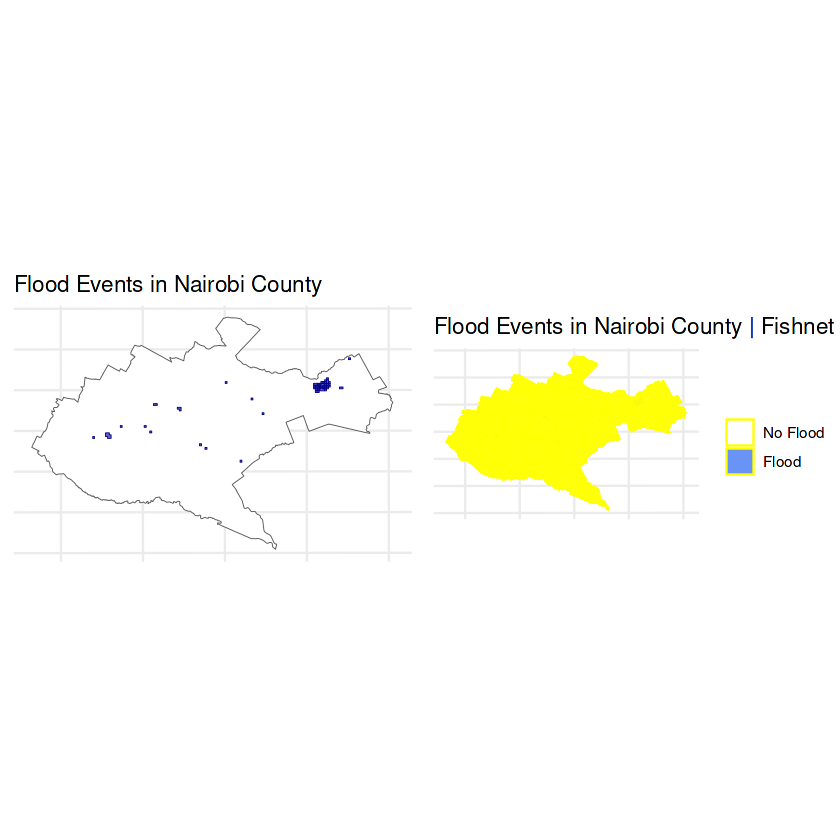

In [9]:
grid.arrange(
  
(ggplot() +
  geom_sf(data = nai_bound,
          fill= 'white')+
  geom_sf(data=flood, 
          fill = "dark blue", 
          color = "dark blue",
          alpha = 0.6) +
  labs(title="Flood Events in Nairobi County") + 
   theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),

(ggplot()+
  geom_sf(data = fishnet_vars, aes(fill = as.factor(FLOOD_INNUN)), color = 'yellow')+
  scale_fill_manual(values = c('#FFFFFF', '#6993f5'),
                    labels = c("No Flood", "Flood"),
                    name = " ")+
  labs(title = 'Flood Events in Nairobi County | Fishnet')+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())), nrow=1)

ggsave('flood_events_Nairobi.png', grid.arrange, device='tiff', dpi=320)

Saving 12.5 x 6.67 in image


ERROR: Error: object of type 'closure' is not subsettable


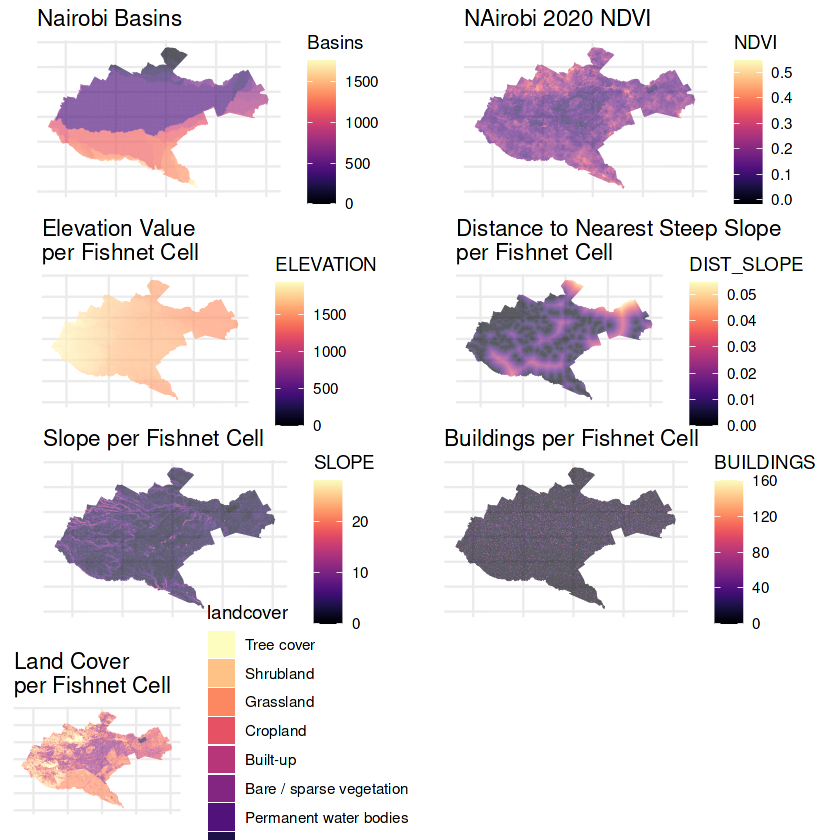

In [10]:
grid.arrange (
  
( ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = BASIN), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1,
#                      discrete= T, # use it when there is factor
                     name = "Basins")+
  labs(title = "Nairobi Basins")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()) ),
 

(ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = NDVI), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1)+
  labs(title = "NAirobi 2020 NDVI")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),
 

(ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = ELEVATION), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1)+
  labs(title = "Elevation Value \nper Fishnet Cell")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),

 (ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = DIST_SLOPE), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1)+
  labs(title = "Distance to Nearest Steep Slope \nper Fishnet Cell")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),

 (ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = SLOPE), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1)+
  labs(title = "Slope per Fishnet Cell")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),
    
 (ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = BUILDINGS), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =1)+
  labs(title = "Buildings per Fishnet Cell")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())),


 (ggplot()+
  geom_sf(data = fishnet_vars, 
          aes(fill = as.factor(LANDCOVER_GROUP)), 
          color= NA)+
  scale_fill_viridis(option = 'A',
                     direction =-1,
                     discrete = T,
                     labels = c("Tree cover", "Shrubland","Grassland", "Cropland", "Built-up", "Bare / sparse vegetation","Permanent water bodies", "Herbaceous wetland", "Other"))+
  labs(title = "Land Cover\nper Fishnet Cell",
fill = "landcover")+
  theme_minimal()+
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank())), 
ncol = 2)

ggsave('Important_Data_Visualized_Nairobi.png', grid.arrange, device='tiff', dpi=320)

## Exploratory Data Analysis

In [11]:
floodPlotVariables <- 
    fishnet_vars %>%
    as.data.frame() %>%
    dplyr::select(FLOOD_INNUN, RIVER, STREAM, DRAINAGE, WATERBODY, LANDCOVER, BASIN, NDVI, BUILDINGS, ELEVATION, SLOPE, DIST_SLOPE, MAJ_STR, MAJ_DRA, MAJ_RIV, MAJ_WAT, LANDCOVER_GROUP) %>% 
    mutate(
#         ELEVATION_CAT = as.factor(ELEVATION_CAT), 
                                            LANDCOVER = as.character(LANDCOVER), 
                                            BASIN_FACTORED = as.factor(BASIN)
    )%>%
    gather(key, value, RIVER:BASIN_FACTORED)

floodPlotVariables$value <- as.numeric(floodPlotVariables$value)

Warning message:
“attributes are not identical across measure variables; they will be dropped”


In [12]:
unique(floodPlotVariables$key)

[1] "RIVER"           "STREAM"          "DRAINAGE"        "WATERBODY"      
 [5] "LANDCOVER"       "BASIN"           "NDVI"            "BUILDINGS"      
 [9] "ELEVATION"       "SLOPE"           "DIST_SLOPE"      "MAJ_STR"        
[13] "MAJ_DRA"         "MAJ_RIV"         "MAJ_WAT"         "LANDCOVER_GROUP"
[17] "BASIN_FACTORED"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


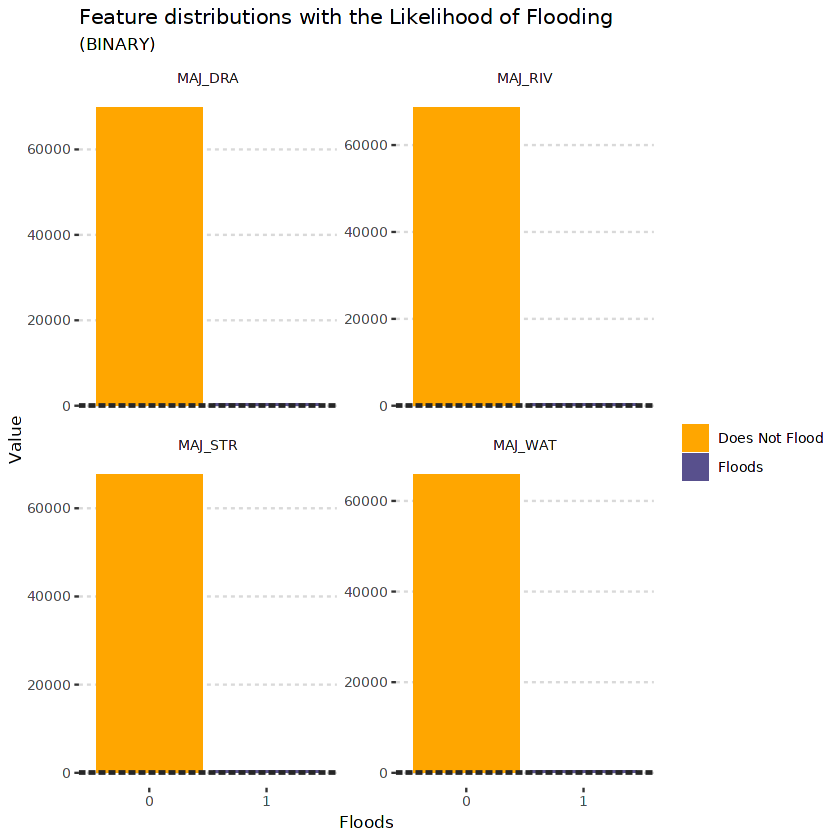

In [13]:
#BINARY VARIABLES
floodPlotVariables%>%
    filter(key %in% c('MAJ_STR', 'MAJ_RIV', 'MAJ_DRA', 'MAJ_WAT'))%>%
    count(key, value, FLOOD_INNUN)%>%
    ggplot(aes(as.factor(FLOOD_INNUN), n, fill= as.factor(FLOOD_INNUN))) +
        geom_bar(stat ="identity", position = "dodge") +
        geom_hline(aes(yintercept = 0), colour = 'grey15',linetype = 5, size = 1)+
        facet_wrap(~key, scales="free_y") +
        scale_fill_manual(values = pal,
                      labels = c("Does Not Flood","Floods"),
                      name = "") +
        labs(title = "Feature distributions with the Likelihood of Flooding",
           subtitle = "(BINARY)",
           x="Floods", y="Value", fill = " ") +
        theme_tufte()+theme(text = element_text(size = 10, family = "TT Arial"),
                      panel.grid.major.y = element_line(color='grey85',linetype = 'dashed')) 
ggsave('BINARY Feature distributions with the Likelihood of Floodin.png', width = width, height = height, device='tiff', dpi=320)

Warning message:
“Removed 1 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_bar()`).”


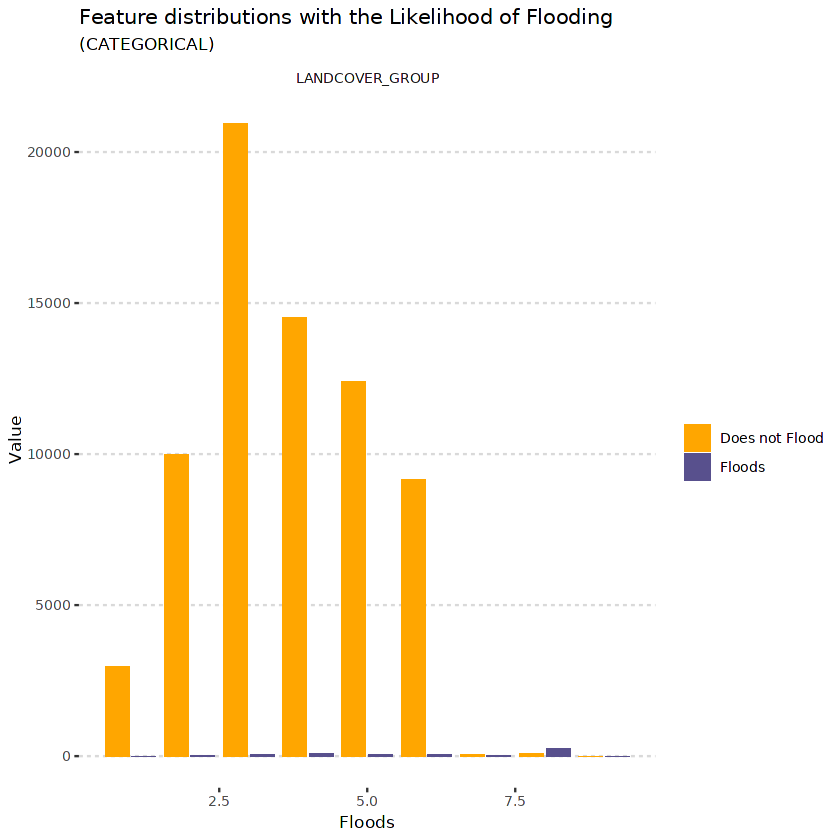

In [14]:
#CATEGORICAL
floodPlotVariables%>%
  filter(key %in% c('LANDCOVER_GROUP'))%>%
  count(key, value, FLOOD_INNUN) %>%
  ggplot(aes(value, n, fill = as.factor(FLOOD_INNUN))) + 
      geom_bar(position = "dodge2", stat = "identity")+
      facet_wrap(~key, scales="free") +
      scale_fill_manual(values = pal, 
                        labels = c("Does not Flood", "Floods"))+
      labs(title = "Feature distributions with the Likelihood of Flooding",
           subtitle = "(CATEGORICAL)",
           x="Floods", y="Value", fill = " ") +
      theme_tufte()+theme(text = element_text(size = 10, family = "TT Arial"),
                      panel.grid.major.y = element_line(color='grey85',linetype = 'dashed'))

ggsave('CATEGORICAL Feature distributions with the Likelihood of Flooding.png', width = width, height = height, device='tiff', dpi=320)

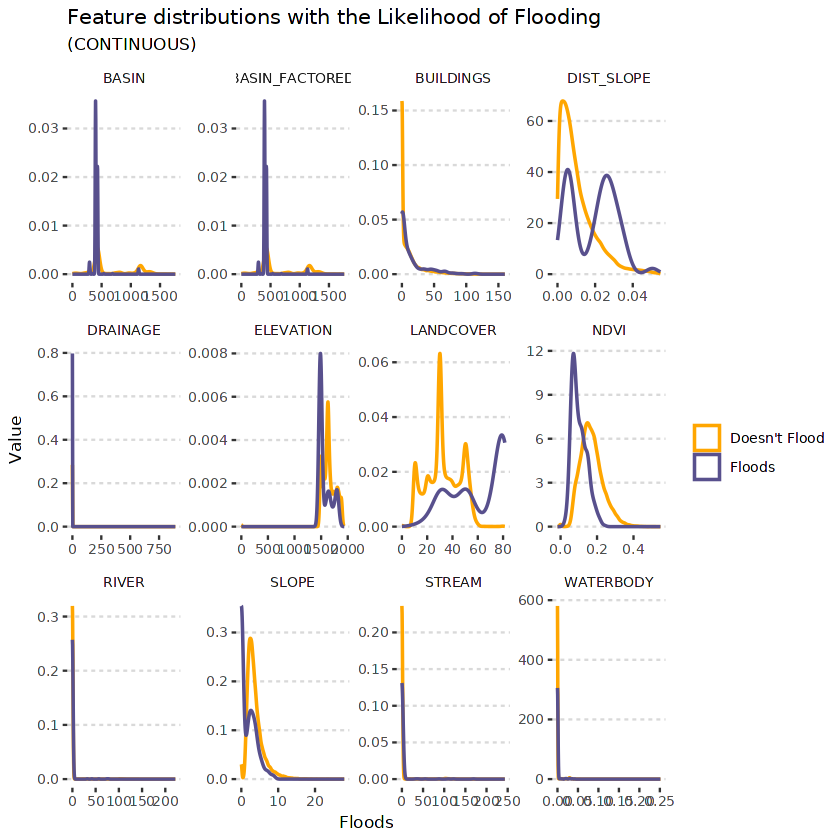

In [15]:
#CONTINUOUS VARIABLES 
floodPlotVariables%>%
    filter(key %in% c('ELEVATION','STREAM','RIVER','DRAINAGE', 'WATERBODY', 'DIST_SLOPE','SLOPE', 'BASIN', 'NDVI', 'LANDCOVER', 'BUILDINGS', 'BASIN_FACTORED'))%>%
    ggplot() + 
    geom_density(aes(value, color= as.factor(FLOOD_INNUN)), size = .75) +
    facet_wrap(~key, scales = "free")+
    scale_color_manual(values = pal, name=" ",labels =c("Doesn't Flood", "Floods"))+
    labs(title = "Feature distributions with the Likelihood of Flooding",
           subtitle = "(CONTINUOUS)", x="Floods", y="Value", color = " ") +
    theme_tufte()+
    theme(text = element_text(size = 10, family = "TT Arial"),
         panel.grid.major.y = element_line(color='grey85',linetype = 'dashed'))

ggsave('CONTINUOUS Feature distributions with the Likelihood of Flooding.png', width = width, height = height, device='tiff', dpi=320)

In [16]:
head(fishnet_vars)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



OID   Shape_Leng Shape_Area FLOOD_INNUN RIVER     BUILDINGS NDVI      
1 1     400        10000      0           111.33569 0         0.08135935
2 10    400        10000      0           101.21155 0         0.12266435
3 100   400        10000      0            41.43713 0         0.20383871
4 1000  400        10000      0           125.67476 0         0.17893280
5 10000 400        10000      0             0.00000 0         0.30172791
6 10001 400        10000      0             0.00000 0         0.13374885
  WATERBODY  STREAM    DRAINAGE   geometry                       ⋯ BASIN
1 0.02869778 101.68290 325.203261 MULTIPOLYGON (((264713.8 98... ⋯ 1202 
2 0.02342748 113.51186   9.836142 MULTIPOLYGON (((264413.8 98... ⋯  429 
3 0.03618087 109.49846  80.349288 MULTIPOLYGON (((246713.8 98... ⋯ 1286 
4 0.03239118  28.89966   0.000000 MULTIPOLYGON (((245513.8 98... ⋯ 1164 
5 0.00000000   0.00000   0.000000 MULTIPOLYGON (((263013.8 98... ⋯ 1164 
6 0.00000000   0.00000   0.000000 MULTIPOLYGON (((245513.8 98... ⋯  429 
  ELEVATION SLOPE    DIST_SLOPE  geometry                       MAJ_STR MAJ_DRA
1 1635.833  2.827701 0.015338793 MULTIPOLYGON (((264713.8 98... 1       1      
2 1616.222  9.321350 0.000318778 MULTIPOLYGON (((264413.8 98... 1       1      
3 1816.444  4.429889 0.002701279 MULTIPOLYGON (((246713.8 98... 1       1      
4 1860.500  3.420392 0.010723854 MULTIPOLYGON (((245513.8 98... 1       0      
5 1624.667  2.714833 0.010224728 MULTIPOLYGON (((263013.8 98... 0       0      
6 1849.538  3.758309 0.006965171 MULTIPOLYGON (((245513.8 98... 0       0      
  MAJ_WAT MAJ_RIV LANDCOVER_GROUP
1 1       1       6              
2 1       1       6              
3 1       1       1              
4 1       1       2              
5 0       0       3              
6 0       0       3

In [17]:
length(fishnet_vars$FLOOD_INNUN)

[1] 70704

## Building the model

In [18]:
#select vars 
# fishnet_vars_model<- 
#     fishnet_vars%>%
#         dplyr::select(FLOOD_INNUN, MAJ_RIV, MAJ_STR, ELEVATION, DIST_SLOPE, BASIN, LANDCOVER, geometry)
fishnet_vars_model<- 
    fishnet_vars%>%
        dplyr::select(FLOOD_INNUN, NDVI, BUILDINGS, ELEVATION, DIST_SLOPE, BASIN, LANDCOVER, geometry)


set.seed(3456)
trainIndex <- createDataPartition(fishnet_vars_model$NDVI, p = .70,
                                  list = FALSE,
                                  times = 1)

floodTrain <- fishnet_vars_model[ trainIndex,]
floodTest  <- fishnet_vars_model[-trainIndex,]

In [20]:
length(floodTrain$NDVI)
length(floodTest$NDVI)

[1] 49496

[1] 21208

In [21]:
floodTrain_2<- floodTrain%>%
    dplyr::select(FLOOD_INNUN, NDVI, BUILDINGS, ELEVATION, DIST_SLOPE, BASIN, LANDCOVER, geometry)

floodModel_2 <- glm(FLOOD_INNUN ~ ., 
                    family="binomial"(link="logit"), data = floodTrain_2%>%
                                                            as.data.frame() %>%
                                                            dplyr::select(-geometry))
summary(floodModel_2)


Call:
glm(formula = FLOOD_INNUN ~ ., family = binomial(link = "logit"), 
    data = floodTrain_2 %>% as.data.frame() %>% dplyr::select(-geometry))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6183  -0.1077  -0.0400  -0.0188   4.4359  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.6756540  1.0781723  -8.974  < 2e-16 ***
NDVI        -6.0067900  1.7606438  -3.412 0.000646 ***
BUILDINGS    0.0036208  0.0028023   1.292 0.196327    
ELEVATION    0.0001609  0.0005420   0.297 0.766528    
DIST_SLOPE  47.3954506  5.8557556   8.094 5.78e-16 ***
BASIN       -0.0014206  0.0003148  -4.512 6.42e-06 ***
LANDCOVER    0.1190968  0.0059518  20.010  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4399.4  on 49495  degrees of freedom
Residual deviance: 2940.5  on 49489  degrees of freedom
AIC: 2954.5

Number of Fisher Scoring iterati

In [22]:
# reg_sum<- broom::tidy(floodModel_2)%>%
#     kable(align = c("l", "r", "r", "r", "r"))%>%
#     kable_styling('striped')%>%
#     footnote(general_title = "Feature Engineered Regression Summary",
#                 general = "Table 1")

# reg_sum

## Model Validation

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


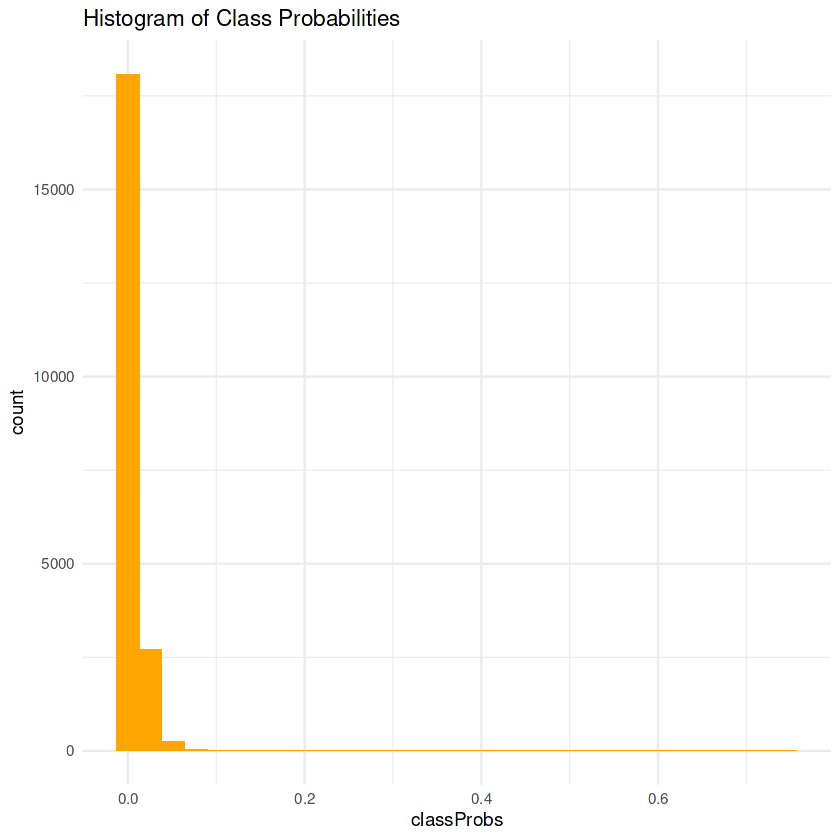

In [23]:
classProbs <- predict(floodModel_2, floodTest, type="response")
# hist(classProbs)
classProbs1 <- as.data.frame(classProbs)

ggplot()+
    geom_histogram(data = classProbs1, aes(classProbs), fill = "#ffa600")+
    labs(title = "Histogram of Class Probabilities")+
    theme_minimal()

ggsave('Histogram of Class Probabilities.png', width = width, height = height, device='tiff', dpi=320)

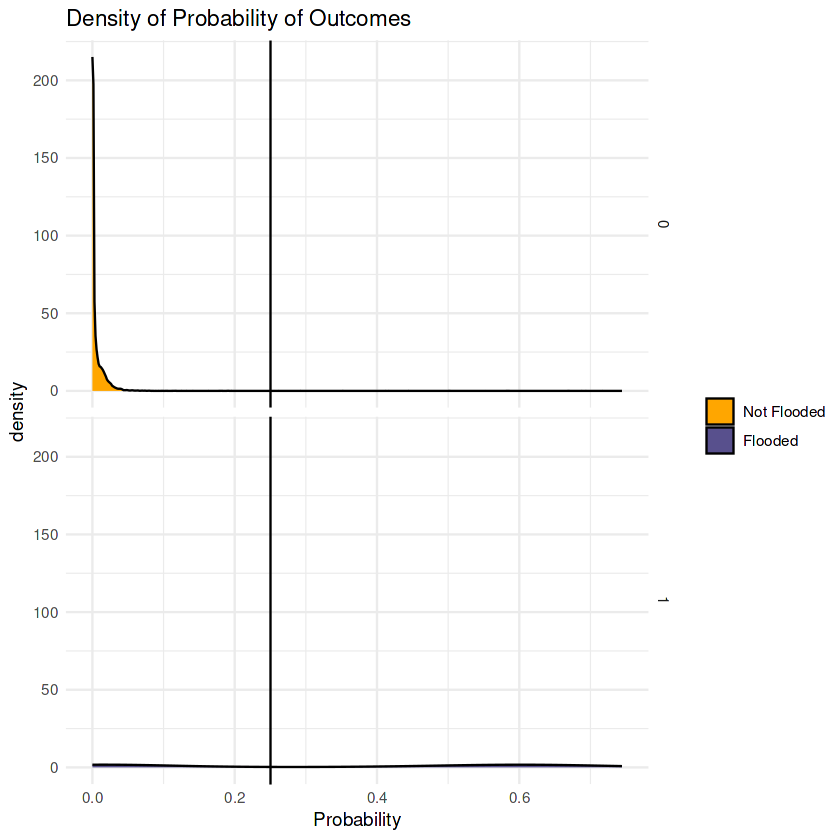

In [24]:
testProbs <- data.frame(obs = as.numeric(floodTest$FLOOD_INNUN),
                        pred = classProbs)


testProbs_map <- floodTest%>%cbind(classProbs)%>%
  mutate(pred =  ifelse(classProbs > .25 ,1,0),
         obs = as.numeric(FLOOD_INNUN))%>%
  mutate(conf = case_when(pred == 1 & obs == 1 ~ "sensitivity", 
                          pred == 0 & obs == 0 ~ "specificity",
                          pred == 0 & obs == 1 ~ "NA", 
                          pred == 1 & obs == 0 ~ "NA"))


conf<-testProbs_map%>%
  filter(conf %in% c("sensitivity", "specificity"))%>%na.omit()

# st_write(conf, 'Data/Calgary/conf.shp')


ggplot(testProbs, aes(x = pred, fill=as.factor(obs))) + geom_density() +
  labs(title = "Density of Probability of Outcomes")+
  facet_grid(obs ~ .) + xlab("Probability") + geom_vline(xintercept = .25) +
  scale_fill_manual(values = pal,
                      labels = c("Not Flooded","Flooded"),
                      name = "")+theme_minimal()

ggsave('Density of Probability of Outcomes.png', width = width, height = height, device='tiff', dpi=320)

In [25]:
testProbs$predClass  = ifelse(testProbs$pred > .25 ,1,0)

conf_matrix<- caret::confusionMatrix(reference = as.factor(testProbs$obs), 
                       data = as.factor(testProbs$predClass), 
                       positive = "1")
conf_matrix$table

          Reference
Prediction     0     1
         0 21054    61
         1    18    75

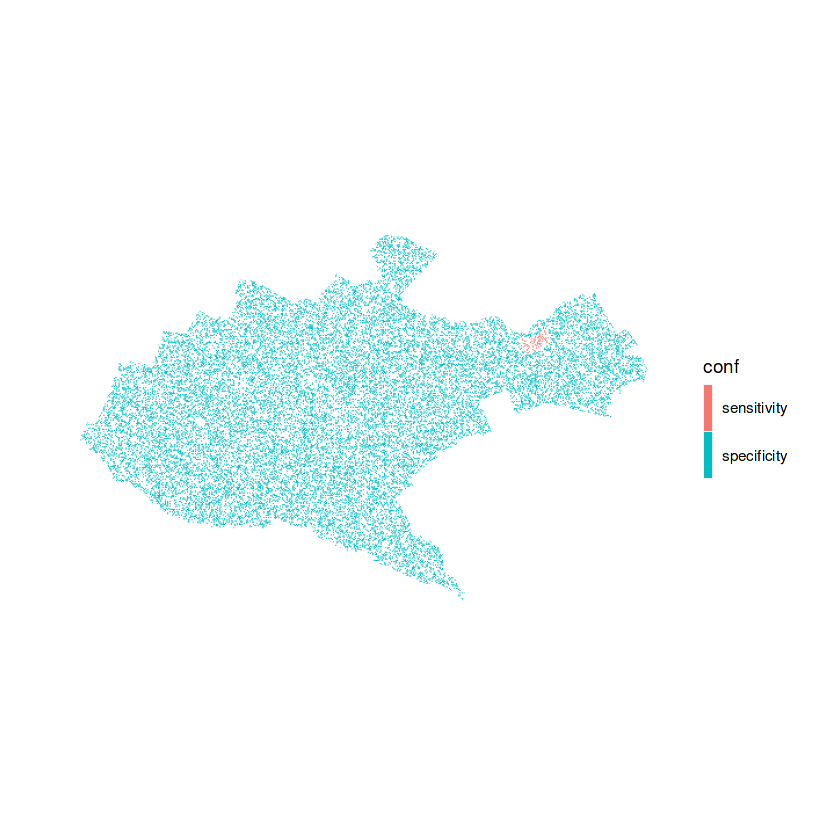

In [26]:
testProbs_map%>%
    filter(conf %in% c("sensitivity", "specificity"))%>%na.omit()%>%
    ggplot()+
        geom_sf(aes(fill = conf), color = NA)+
        mapTheme

ggsave('Test probability (sensitivity_specificity.png', width = width, height = height, device='tiff', dpi=320)

Warning message:
“The following aesthetics were dropped during statistical transformation: d, m
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: d, m
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


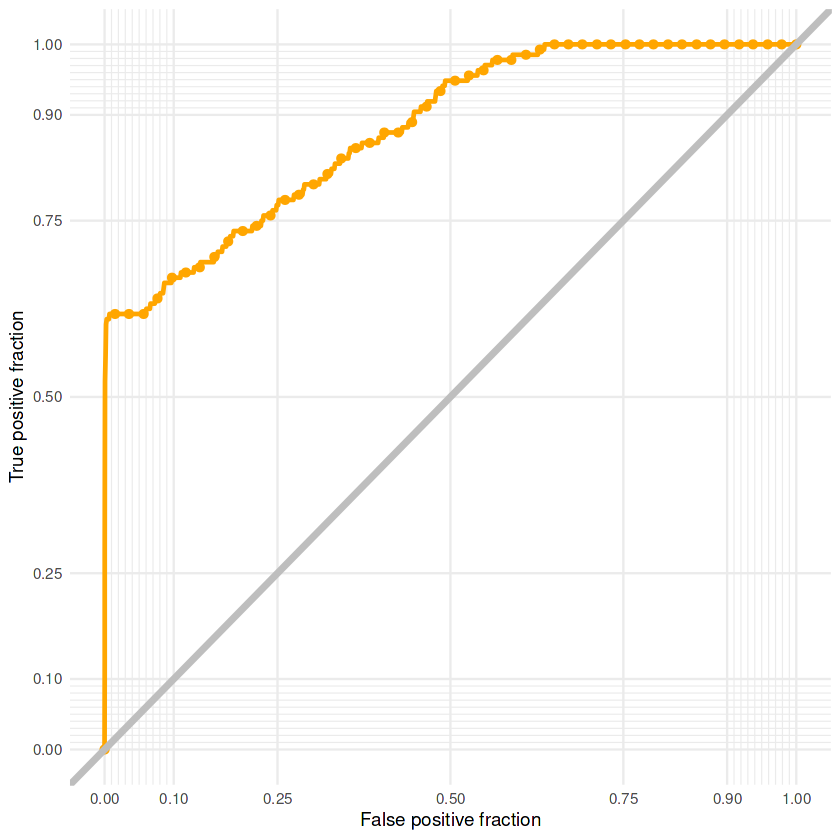

In [27]:
ggplot(testProbs, aes(d = obs, m = pred)) + 
    geom_roc(n.cuts = 50, labels = FALSE, color = '#ffa600') + 
    style_roc(theme = theme_grey) +
    geom_abline(slope = 1, intercept = 0, size = 1.5, color = 'grey')+
    theme_minimal()

ggsave('Area under the curve.png', width = width, height = height, device='tiff', dpi=320)

In [28]:
auc(testProbs$obs, testProbs$pred)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8792

### Cross Validation

In [29]:
ctrl <- trainControl(method = "cv", 
                     number = 100, 
                     savePredictions = TRUE)

fishnet_vars_model[is.na(fishnet_vars_model)] = 0

cvFit <- train(as.factor(FLOOD_INNUN) ~ .,  data = fishnet_vars_model %>% 
                                                as.data.frame() %>%
                                                dplyr::select(-geometry), 
               method="glm", family="binomial",
               trControl = ctrl)

cvFit$results%>%kable()%>%
  kable_styling('striped')%>%
  footnote(general_title = "100 Fold Cross Validation Summary",
           general = "Table 2")

<table class="table table-striped" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
 <thead>
  <tr>
   <th style="text-align:left;"> parameter </th>
   <th style="text-align:right;"> Accuracy </th>
   <th style="text-align:right;"> Kappa </th>
   <th style="text-align:right;"> AccuracySD </th>
   <th style="text-align:right;"> KappaSD </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> none </td>
   <td style="text-align:right;"> 0.995163 </td>
   <td style="text-align:right;"> 0.5132278 </td>
   <td style="text-align:right;"> 0.0017079 </td>
   <td style="text-align:right;"> 0.2140741 </td>
  </tr>
</tbody>
<tfoot>
<tr><td style="padding: 0; " colspan="100%"><span style="font-style: italic;">100 Fold Cross Validation Summary</span></td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup></sup> Table 2</td></tr>
</tfoot>
</table>

In [30]:
summary(cvFit)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6672  -0.1019  -0.0366  -0.0169   4.4989  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.036e+01  1.056e+00  -9.808  < 2e-16 ***
NDVI        -5.937e+00  1.529e+00  -3.883 0.000103 ***
BUILDINGS    3.751e-03  2.431e-03   1.543 0.122872    
ELEVATION    3.490e-04  5.346e-04   0.653 0.513846    
DIST_SLOPE   5.141e+01  5.186e+00   9.915  < 2e-16 ***
BASIN       -1.430e-03  2.749e-04  -5.203 1.96e-07 ***
LANDCOVER    1.237e-01  5.166e-03  23.934  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6046.8  on 70703  degrees of freedom
Residual deviance: 3902.2  on 70697  degrees of freedom
AIC: 3916.2

Number of Fisher Scoring iterations: 10


Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


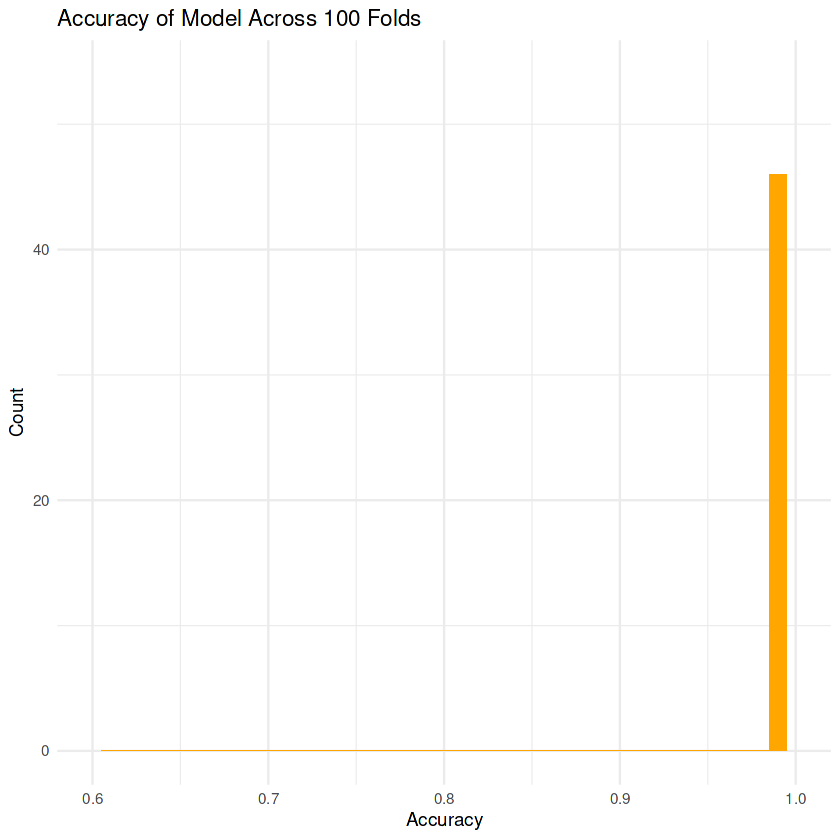

In [31]:
ggplot(as.data.frame(cvFit$resample), aes(Accuracy)) + 
    geom_histogram(bins = 20, binwidth = .01, fill = '#ffa600') +
    scale_x_continuous(limits = c(.6, 1)) +
    labs(title= "Accuracy of Model Across 100 Folds",
    x="Accuracy",
       y="Count")+
    theme_minimal()

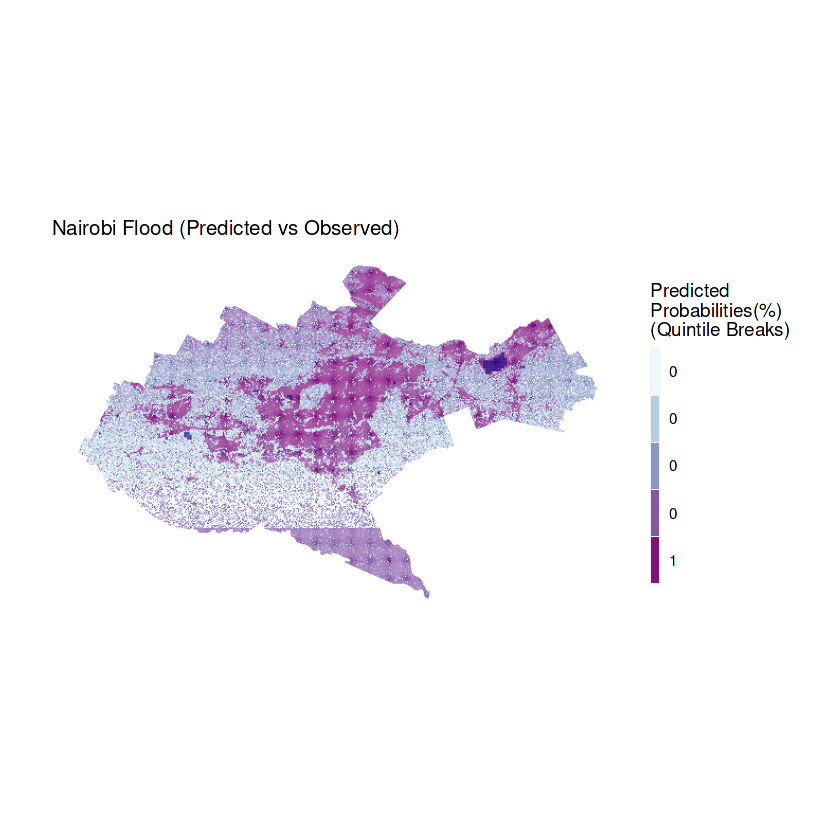

In [32]:
allPredictions <- 
    predict(cvFit, fishnet_vars_model, type="prob")[,2]

fishnet_vars_model1 <- 
    cbind(fishnet_vars_model,allPredictions) %>%
    mutate(allPredictions = round(allPredictions * 100)) 

ggplot() + 
    geom_sf(data=fishnet_vars_model1, aes(fill=factor(ntile(allPredictions,5))), colour=NA) +
    scale_fill_manual(values = c("#edf8fb","#b3cde3","#8c96c6","#8856a7","#810f7c"),
                      labels=as.character(quantile(fishnet_vars_model1$allPredictions,
                                                 c(0.1,.2,.4,.6,.8),na.rm=T)),
                      name="Predicted\nProbabilities(%)\n(Quintile Breaks)") +
  geom_sf(data=flood, 
          fill = "dark blue", 
          color = NA,
          alpha = 0.6) +
  mapTheme +
  labs(title="Nairobi Flood (Predicted vs Observed)")

ggsave('Nairobi Flood (Predicted vs Observed).png', width = width, height = height, device='tiff', dpi=320)
# ggsave('Nairobi Flood (Predicted vs Observed).tiff', width = width, height = height, device='tiff', dpi=700)

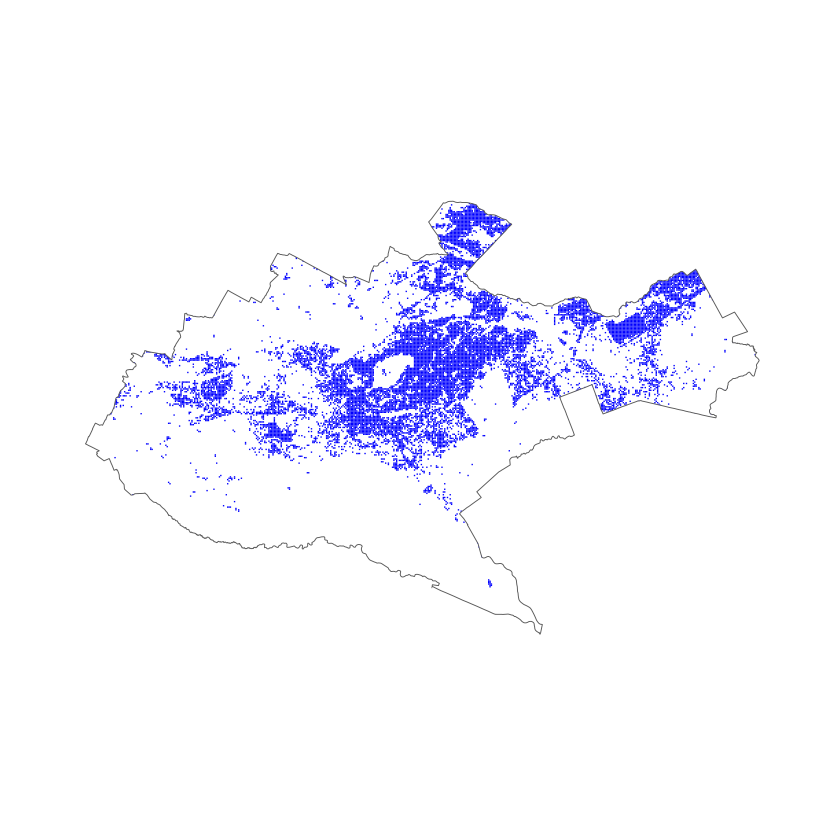

In [33]:
fishnet_vars_model1<-
  fishnet_vars_model1 %>%
  mutate(pit_flood = factor(ntile(allPredictions, 5)))

pit_flood<- fishnet_vars_model1%>%
  filter(pit_flood == 5)


pit_flood2<- fishnet_vars_model1%>%
  filter(pit_flood == 4)

ggplot()+
  geom_sf(data = pit_flood, fill = 'blue', color = NA)+
  geom_sf(data= nai_bound, fill = NA, color = 'grey35', size = 1)+
  mapTheme

ggsave('Nairobi Flood (Predicted).png', width = width, height = height, device='tiff', dpi=320)